In [1]:
import bayes3d as b
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
import cv2

In [3]:

intrinsics = b.Intrinsics(
    height=300,
    width=300,
    fx=500.0, fy=500.0,
    cx=150.0, cy=150.0,
    near=0.01, far=10.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=10.0/1000.0)

# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (320, 320, 1024)


In [10]:
IDX = 11
frames = 40
dots = 25
pc = jnp.array(b.RENDERER.meshes[IDX].vertices)
point_rad = 5


pc_subsamples = pc[jax.random.choice(jax.random.PRNGKey(10), jnp.arange(pc.shape[0]), shape=(frames, dots) )]

    

#### Use noisy points since RANSAC is robust to outlier features

turn off noise for RANSAC to check correctness first

In [15]:
pix_subsample0 = b.project_cloud_to_pixels(pc_subsamples[0], intrinsics)
pix_subsample1 = b.project_cloud_to_pixels(pc_subsamples[1], intrinsics)

In [16]:
poses = jnp.array([b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
)) @ b.t3d.transform_from_axis_angle(jnp.array([1.0, 0.0, 1.0]), angle) for angle in jnp.linspace(0.0, 4*jnp.pi, frames)])



In [18]:
# find fundamental matrix
# essential matrix generates point in im1 given a corresponding point in im0

pix_subsample0 = np.asarray(pix_subsample0)
pix_subsample1 = np.asarray(pix_subsample1)

out = cv2.findFundamentalMat(points1 = pix_subsample0, points2 = pix_subsample1, method = cv2.FM_RANSAC, ransacReprojThreshold=3, confidence = 0.99)
F = out[0]
K = np.array([[intrinsics.fx, 0, intrinsics.cx],[0, intrinsics.fy, intrinsics.cy],[0,0,1]])

#E = K' * F * K
E = K.T @ F @ K
print(E)

[[ 8.09728575  3.86596448 -0.70009635]
 [ 2.63025152 -1.39547989  0.93329349]
 [-0.62575189  0.31024501 -0.21251489]]


In [21]:
pix_subsample0 = b.project_cloud_to_pixels(pc_subsamples[0], intrinsics)
print(pc_subsamples.shape)
print(pix_subsample0.shape)

(40, 25, 3)
(25, 2)


In [23]:
# need camera_params, points_3d, camera_indices, point_indices, points_2d

proj_cloud = lambda pc_sample: b.project_cloud_to_pixels(pc_sample, intrinsics)
pcloud_parallel_jit = jax.jit(jax.vmap(proj_cloud))



points_3d = pc_subsamples
points_2d = pcloud_parallel_jit(points_3d)
print(points_2d.shape)
camera_params = intrinsics

d, f = np.meshgrid(range(dots), range(frames))
camera_indices = f.flatten()
point_indices = d.flatten()

#assert (points_3d[camera_indices[1]*dots+point_indices[0],:] == pc_subsamples[camera_indices[1],point_indices[0],:]).all()

(40, 25, 2)


In [22]:
n_cameras = points_3d.shape[0]
n_points = points_3d.shape[1]

# K = np.array([[intrinsics.fx, 0, intrinsics.cx],[0, intrinsics.fy, intrinsics.cy],[0,0,1]])

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters: 23769
Total number of residuals: 63686


In [71]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v


In [69]:
# def project(points, camera_params):
#     """Convert 3-D points to 2-D by projecting onto images."""
#     points_proj = rotate(points, camera_params[:, :3])
#     points_proj += camera_params[:, 3:6]
#     points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
#     f = camera_params[:, 6]
#     k1 = camera_params[:, 7]
#     k2 = camera_params[:, 8]
#     n = np.sum(points_proj**2, axis=1)
#     r = 1 + k1 * n + k2 * n**2
#     points_proj *= (r * f)[:, np.newaxis]
#     return points_proj

def project(points, intrinsics):
    return b.project_cloud_to_pixels(points, intrinsics)

In [25]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    # camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], intrinsics[camera_indices])
    return (points_proj - points_2d).ravel()

In [26]:
from scipy.sparse import lil_matrix


In [27]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return A

In [77]:
for i in cameras
pix = b.project_cloud_to_pixels(pc_est,int_est)

TypeError: 'int' object is not subscriptable

In [28]:
import matplotlib.pyplot as plt


In [29]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))


In [30]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)


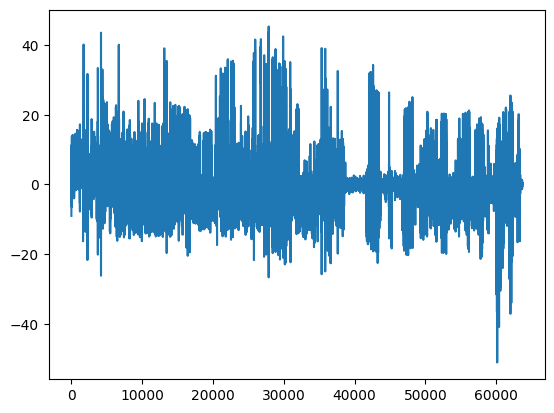

In [31]:
plt.plot(f0)


In [32]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)


In [33]:
import time
from scipy.optimize import least_squares


### CUDA-compatible least squares solver?

In [34]:
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    8.57e+06    
       1              3         5.0985e+04      8.00e+05       1.46e+02       1.15e+06    
       2              4         1.6077e+04      3.49e+04       2.59e+01       2.43e+05    
       3              5         1.4163e+04      1.91e+03       2.86e+02       1.21e+05    
       4              7         1.3695e+04      4.67e+02       1.32e+02       2.51e+04    
       5              8         1.3481e+04      2.14e+02       2.24e+02       1.54e+04    
       6              9         1.3436e+04      4.54e+01       3.18e+02       2.73e+04    
       7             10         1.3422e+04      1.37e+01       6.83e+01       2.20e+03    
       8             11         1.3418e+04      3.70e+00       1.28e+02       7.90e+03    
       9             12         1.3414e+04      4.20e+00       2.64e+01       6.22e+02    

In [35]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))


Optimization took 23 seconds


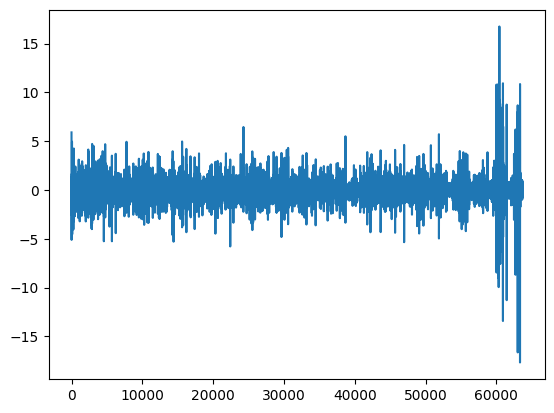

In [36]:
plt.plot(res.fun)


In [2]:
R = b.t3d.rotation_from_axis_angle(jnp.array([1/jnp.sqrt(3),-1/jnp.sqrt(3),1/jnp.sqrt(3)]),-jnp.pi/3)
ax, ang = b.t3d.axis_angle_from_rotation(R)

In [3]:
ax, ang

(Array([-0.57734394,  0.577363  , -0.57734394], dtype=float32),
 Array(1.0471919, dtype=float32))

In [11]:
b.t3d.rodrigues_from_rotation(R)

Array([-1.9359153e-05, -1.9359153e-05,  0.0000000e+00], dtype=float32)

In [12]:
jnp.linalg.norm(b.t3d.rodrigues_from_rotation(R))

Array(2.7377977e-05, dtype=float32)

In [13]:
[1/jnp.sqrt(3),-1/jnp.sqrt(3),1/jnp.sqrt(3)]

[Array(0.57735026, dtype=float32, weak_type=True),
 Array(-0.57735026, dtype=float32, weak_type=True),
 Array(0.57735026, dtype=float32, weak_type=True)]

In [14]:
b.t3d.rodrigues_from_rotation(R)

Array([-1.9359153e-05, -1.9359153e-05,  0.0000000e+00], dtype=float32)

In [15]:
jnp.pi/3

1.0471975511965976

In [10]:
tarr = jnp.array([[1/jnp.sqrt(3),-1/jnp.sqrt(3),1/jnp.sqrt(3)], [1,1,0],[1,1,0], [1,-1,1]])
tang = jnp.array([-jnp.pi/3, jnp.pi, 0, jnp.pi-0.0001])

In [11]:
ax_ang_p_jit = jax.jit(jax.vmap(b.t3d.axis_angle_from_rotation))
rot_jit = jax.jit(jax.vmap(b.t3d.rotation_from_axis_angle))

In [12]:
Rs = rot_jit(tarr, tang)
Rs


Array([[[ 6.6666669e-01,  3.3333337e-01,  6.6666675e-01],
        [-6.6666675e-01,  6.6666669e-01,  3.3333337e-01],
        [-3.3333337e-01, -6.6666675e-01,  6.6666669e-01]],

       [[-5.9604645e-08,  9.9999994e-01, -6.1817239e-08],
        [ 9.9999994e-01, -5.9604645e-08,  6.1817239e-08],
        [ 6.1817239e-08, -6.1817239e-08, -1.0000000e+00]],

       [[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[-3.3333308e-01, -6.6724384e-01,  6.6608906e-01],
        [-6.6608906e-01, -3.3333308e-01, -6.6724384e-01],
        [ 6.6724384e-01, -6.6608906e-01, -3.3333308e-01]]], dtype=float32)

In [13]:
ax, ang = ax_ang_p_jit(Rs)
print(ax)
print(ang)

[[-5.7735032e-01  5.7735032e-01 -5.7735032e-01]
 [ 7.0710677e-01  7.0710677e-01  3.1830986e-11]
 [ 5.7735026e-01  5.7735026e-01  5.7735026e-01]
 [ 5.7735026e-01 -5.7735026e-01  5.7735026e-01]]
[1.0471976e+00 3.1415932e+00 1.7320509e-10 3.7145543e+00]


In [20]:
def axis_angle_from_rotation_stable(R):
    rvec = rodrigues_from_rotation_stable(R)
    if not jnp.any(rvec):
        return jnp.array([1,0,0]), 0
    return rvec/jnp.linalg.norm(rvec), jnp.linalg.norm(rvec)

def rodrigues_from_rotation_stable(R):
    #formula from http://motion.pratt.duke.edu/RoboticSystems/3DRotations.html
    theta = jnp.arccos((jnp.trace(R)-1)/2)
    if jnp.isclose(theta, 0):
        rvec = jnp.array([0,0,0])
    elif jnp.isclose(theta, jnp.pi):
        eval, evec = jnp.linalg.eigh(R)
        rvec = evec[:,jnp.isclose(eval,1)].reshape(-1)
        #take positive first value
        rvec = theta * jnp.sign(rvec[0])/jnp.linalg.norm(rvec) * rvec
    else:
        #set sign based on angle
        rvec = jnp.array([(R[2,1]-R[1,2])/(2*jnp.sin(theta)), (R[0,2]-R[2,0])/(2*jnp.sin(theta)), (R[1,0]-R[0,1])/(2*jnp.sin(theta))]) * theta
    return rvec.reshape(-1)